# Face Expression Detection

Dataset: https://www.kaggle.com/datasets/jonathanoheix/face-expression-recognition-dataset

Steps:
1. train a classifier
2. evaluate the classifier (accuracy, precision, recall & confusion matrix)
3. build a detection pipeline:
 1. detect a face in an image
 2. extract the face & classify the expression

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch2trt import torch2trt
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
import pandas as pd
import seaborn as sn
import cv2
import PIL
import time
from IPython import display

In [2]:
BATCH_SIZE = 32
IMAGE_SIZE = 48

In [3]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

device

device(type='cuda')

In [4]:
transformer = transforms.Compose([
    transforms.Resize(IMAGE_SIZE),
    transforms.Grayscale(),
    transforms.ToTensor()
])

full_train_dataset = torchvision.datasets.ImageFolder('./images/train', transform=transformer)
n = len(full_train_dataset)
n_validation = int(0.1 * n)
n_train = n - n_validation
validation_dataset, train_dataset = torch.utils.data.random_split(full_train_dataset, [n_validation, n_train])
test_dataset = torchvision.datasets.ImageFolder('./images/validation', transform=transformer)

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
validation_dataloader = DataLoader(validation_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [5]:
labels_map = { v: k for k, v in full_train_dataset.class_to_idx.items() }
labels_map

{0: 'angry',
 1: 'disgust',
 2: 'fear',
 3: 'happy',
 4: 'neutral',
 5: 'sad',
 6: 'surprise'}

In [6]:
batch = next(iter(train_dataloader))
images = batch[0]
labels = batch[1]

_, axs = plt.subplots(8, BATCH_SIZE // 8, figsize=(10, 10))

for i in range(BATCH_SIZE):
    x = i // (BATCH_SIZE // 8)
    y = i % (BATCH_SIZE // 8)
    image = images[i]
    label = labels[i]
    axs[x, y].imshow(image.reshape((IMAGE_SIZE, IMAGE_SIZE)))
    axs[x, y].set_title(f'Label: {labels_map[label.item()]}')

## Simple fully connected feed-forward NN

In [7]:
class ExpressionClassifier(nn.Module):
    def __init__(self, class_count):
        super(ExpressionClassifier, self).__init__()
        
        self.network = nn.Sequential(
            nn.Linear(IMAGE_SIZE ** 2, 2048),
            nn.LeakyReLU(),
            nn.Dropout(0.1),
            nn.Linear(2048, 1024),
            nn.LeakyReLU(),
            nn.Dropout(0.1),
            nn.Linear(1024, 512),
            nn.LeakyReLU(),
            nn.Dropout(0.1),
            nn.Linear(512, 256),
            nn.LeakyReLU(),
            nn.Dropout(0.1),
            nn.Linear(256, class_count)
        )
        
    def forward(self, x):
        x = x.view(-1, IMAGE_SIZE ** 2)
        return self.network(x)
    
model = ExpressionClassifier(len(labels_map)).to(device)

model

ExpressionClassifier(
  (network): Sequential(
    (0): Linear(in_features=4096, out_features=2048, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Dropout(p=0.1, inplace=False)
    (3): Linear(in_features=2048, out_features=1024, bias=True)
    (4): LeakyReLU(negative_slope=0.01)
    (5): Dropout(p=0.1, inplace=False)
    (6): Linear(in_features=1024, out_features=512, bias=True)
    (7): LeakyReLU(negative_slope=0.01)
    (8): Dropout(p=0.1, inplace=False)
    (9): Linear(in_features=512, out_features=256, bias=True)
    (10): LeakyReLU(negative_slope=0.01)
    (11): Dropout(p=0.1, inplace=False)
    (12): Linear(in_features=256, out_features=7, bias=True)
  )
)

## CNN + fully connected NN

In [8]:
class CnnExpressionClassifier(nn.Module):
    def __init__(self, class_count):
        super(CnnExpressionClassifier, self).__init__()
        
        self.network = nn.Sequential(
            nn.Conv2d(1, 6, 3),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(6, 12, 3),
            nn.MaxPool2d(2, 2),
            nn.Flatten(),
            nn.Linear(1200, 64),
            nn.LeakyReLU(),
            nn.Dropout(0.1),
            nn.Linear(64, 32),
            nn.LeakyReLU(),
            nn.Dropout(0.1),
            nn.Linear(32, class_count)
        )
        
    def forward(self, x):
        x = x.view(-1, 1, IMAGE_SIZE, IMAGE_SIZE)
        return self.network(x)
    
model = CnnExpressionClassifier(len(labels_map)).to(device)

model

CnnExpressionClassifier(
  (network): Sequential(
    (0): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): Conv2d(6, 12, kernel_size=(3, 3), stride=(1, 1))
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Flatten(start_dim=1, end_dim=-1)
    (5): Linear(in_features=1200, out_features=64, bias=True)
    (6): LeakyReLU(negative_slope=0.01)
    (7): Dropout(p=0.1, inplace=False)
    (8): Linear(in_features=64, out_features=32, bias=True)
    (9): LeakyReLU(negative_slope=0.01)
    (10): Dropout(p=0.1, inplace=False)
    (11): Linear(in_features=32, out_features=7, bias=True)
  )
)

In [9]:
model(images.to(device))

tensor([[ 0.0207, -0.1713,  0.1285, -0.1862,  0.0490, -0.1290,  0.0314],
        [ 0.0281, -0.1492,  0.1391, -0.1607,  0.0076, -0.1133,  0.0377],
        [ 0.0076, -0.1304,  0.1286, -0.1484,  0.0115, -0.1280,  0.0568],
        [ 0.0178, -0.1390,  0.1557, -0.1701,  0.0338, -0.1190,  0.0060],
        [ 0.0297, -0.1817,  0.1339, -0.1832,  0.0421, -0.1266,  0.0291],
        [ 0.0242, -0.1551,  0.1415, -0.1684,  0.0174, -0.1091,  0.0284],
        [ 0.0138, -0.1459,  0.1410, -0.1547,  0.0060, -0.1158,  0.0397],
        [-0.0039, -0.1132,  0.1340, -0.1425, -0.0150, -0.1268,  0.0582],
        [ 0.0432, -0.1515,  0.1317, -0.1667,  0.0138, -0.1054,  0.0412],
        [ 0.0128, -0.1279,  0.1419, -0.1534,  0.0081, -0.1194,  0.0511],
        [ 0.0077, -0.1287,  0.1566, -0.1623, -0.0042, -0.1124,  0.0489],
        [ 0.0286, -0.1500,  0.1251, -0.1713,  0.0140, -0.1324,  0.0579],
        [ 0.0313, -0.1630,  0.1292, -0.1761,  0.0282, -0.1213,  0.0429],
        [ 0.0272, -0.1528,  0.1429, -0.1731,  0.027

In [10]:
loss_function = nn.CrossEntropyLoss()

optimizer = optim.Adam(model.parameters(), lr=0.001)

In [11]:
train_losses = []
val_losses = []

for epoch in range(15):
    print('Epoch:', epoch+1)
    
    epoch_train_losses = []
    epoch_val_losses = []
    
    batch_count = len(train_dataloader)
    val_batch_count = len(validation_dataloader)
    
    model.train()
    for index, batch in enumerate(train_dataloader):
        if index % 200 == 0:
            print('Batch:', index+1, '/', batch_count)
        [images, labels] = batch
        images = images.to(device)
        labels = labels.to(device)
        
        model.zero_grad()
        
        logits = model(images)
        loss = loss_function(logits, labels)
        
        loss.backward()
        optimizer.step()
        
        epoch_train_losses.append(loss.item())
    print('Train loss:', np.mean(epoch_train_losses))
    train_losses.append(np.mean(epoch_train_losses))
    
    model.eval()
    with torch.no_grad():
        for index, batch in enumerate(validation_dataloader):
            if index % 200 == 0:
                print('Val Batch:', index+1, '/', val_batch_count)
            [images, labels] = batch
            images = images.to(device)
            labels = labels.to(device)

            logits = model(images)
            loss = loss_function(logits, labels)

            epoch_val_losses.append(loss.item())
    print('Val loss:', np.mean(epoch_val_losses))
    val_losses.append(np.mean(epoch_val_losses))

Epoch: 1
Batch: 1 / 811
Batch: 201 / 811
Batch: 401 / 811
Batch: 601 / 811
Batch: 801 / 811
Train loss: 1.7269950573012214
Val Batch: 1 / 91
Val loss: 1.5912343853122586
Epoch: 2
Batch: 1 / 811
Batch: 201 / 811
Batch: 401 / 811
Batch: 601 / 811
Batch: 801 / 811
Train loss: 1.5309907281736852
Val Batch: 1 / 91
Val loss: 1.4413383648945735
Epoch: 3
Batch: 1 / 811
Batch: 201 / 811
Batch: 401 / 811
Batch: 601 / 811
Batch: 801 / 811
Train loss: 1.4195009786750474
Val Batch: 1 / 91
Val loss: 1.3802793654766712
Epoch: 4
Batch: 1 / 811
Batch: 201 / 811
Batch: 401 / 811
Batch: 601 / 811
Batch: 801 / 811
Train loss: 1.3381114646921028
Val Batch: 1 / 91
Val loss: 1.335354650249848
Epoch: 5
Batch: 1 / 811
Batch: 201 / 811
Batch: 401 / 811
Batch: 601 / 811
Batch: 801 / 811
Train loss: 1.2715984455019271
Val Batch: 1 / 91
Val loss: 1.3115287213535098
Epoch: 6
Batch: 1 / 811
Batch: 201 / 811
Batch: 401 / 811
Batch: 601 / 811
Batch: 801 / 811
Train loss: 1.2126535313931994
Val Batch: 1 / 91
Val loss: 

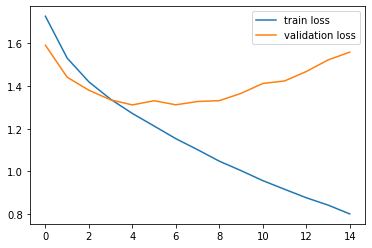

In [12]:
plt.plot(train_losses, label='train loss')
plt.plot(val_losses, label='validation loss')
plt.legend(loc='best')
plt.show()

In [13]:
y_list = []
logit_list = []
epoch_test_losses = []    
batch_count = len(test_dataloader)
model.eval()
with torch.no_grad():
    for index, batch in enumerate(test_dataloader):
        if index % 200 == 0:
            print('Test Batch:', index+1, '/', batch_count)
        [images, labels] = batch
        images = images.to(device)
        labels = labels.to(device)

        logits = model(images)
        loss = loss_function(logits, labels)
        
        logit_list.append(logits.detach().cpu())
        y_list.append(labels.detach().cpu())

        epoch_test_losses.append(loss.item())

print('Test loss:', np.mean(epoch_test_losses))
logit_list = torch.concat(logit_list, dim=0)
y_list = torch.concat(y_list, dim=0)

Test Batch: 1 / 221
Test Batch: 201 / 221
Test loss: 1.5244999414655418


In [14]:
y_pred = torch.argmax(logit_list, dim=1)

print('Precision:', precision_score(y_list, y_pred, average=None))
print('Recall:', recall_score(y_list, y_pred, average=None))
print('F1 Score:', f1_score(y_list, y_pred, average=None))

Precision: [0.4041721  0.53846154 0.35468565 0.68399382 0.4552     0.3540856
 0.58926616]
Recall: [0.32291667 0.31531532 0.29371316 0.72821918 0.46792763 0.39947322
 0.67503137]
F1 Score: [0.35900405 0.39772727 0.32133262 0.70541401 0.46147607 0.37541254
 0.62923977]


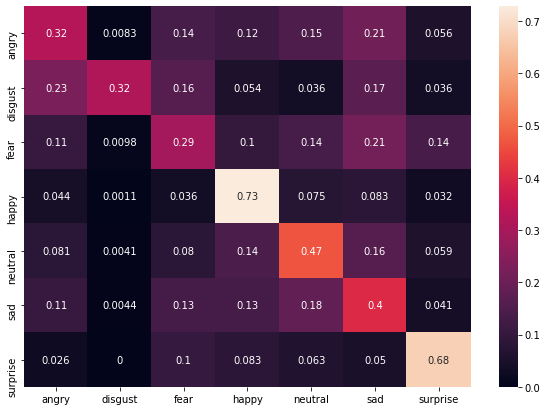

In [15]:
matrix = confusion_matrix(y_true=y_list, y_pred=y_pred, normalize='true')

matrix_df = pd.DataFrame(matrix, index=labels_map.values(), columns=labels_map.values())

plt.figure(figsize = (10,7))
sn.heatmap(matrix_df, annot=True)
plt.show()

As seen, the model is good to detect happy faces (73% accuracy), it struggles with fear which it confuses with sad faces (21% confusion)

In [16]:
torch.save(model, 'faceexpression.bin')

In [17]:
model = torch.load('faceexpression.bin').to(device)
model.eval()

CnnExpressionClassifier(
  (network): Sequential(
    (0): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): Conv2d(6, 12, kernel_size=(3, 3), stride=(1, 1))
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Flatten(start_dim=1, end_dim=-1)
    (5): Linear(in_features=1200, out_features=64, bias=True)
    (6): LeakyReLU(negative_slope=0.01)
    (7): Dropout(p=0.1, inplace=False)
    (8): Linear(in_features=64, out_features=32, bias=True)
    (9): LeakyReLU(negative_slope=0.01)
    (10): Dropout(p=0.1, inplace=False)
    (11): Linear(in_features=32, out_features=7, bias=True)
  )
)

In [18]:
classifier = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')

In [19]:
cap = cv2.VideoCapture(0)

success = False
while not success:
    success, img = cap.read()
    time.sleep(0.1)
cap.release()
del cap
image = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.imshow(image)
plt.show()

image.shape

(480, 640, 3)

In [21]:
boxes = classifier.detectMultiScale(image)
bounding_boxes = [(x, y, x + width, y + height) for x, y, width, height in boxes ]
bounding_boxes.sort(key=lambda box: (box[2]-box[0])*(box[3]-box[1]), reverse=True)

bounding_boxes

[(195, 166, 312, 283)]

In [22]:
face_box = bounding_boxes[0]

(x1, y1, x2, y2) = face_box

face = image[y1:y2, x1:x2, :]

face.shape

(117, 117, 3)

In [23]:
emoji_map = {
    0: '😡',
    1: '🤮',
    2: '😱',
    3: '🥳',
    4: '😐',
    5: '😢',
    6: '😵'}

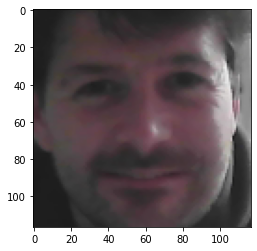

Label: happy 🥳, probability: 0.9774513840675354


In [24]:
face_tensor = PIL.Image.fromarray(face)
face_tensor = transformer(face_tensor)
face_tensor = face_tensor.to(device)
face_tensor = face_tensor.view(1, 1, IMAGE_SIZE, IMAGE_SIZE)

with torch.no_grad():
    probs = nn.functional.softmax(model(face_tensor).detach().cpu(), dim=1)[0]
    
label = torch.argmax(probs).item()

plt.imshow(face)
plt.show()

print(f'Label: {labels_map[label]} {emoji_map[label]}, probability: {probs[label]}')

Label: happy 🥳, probability: 0.47786545753479004
E2E Latency: 0.830430269241333


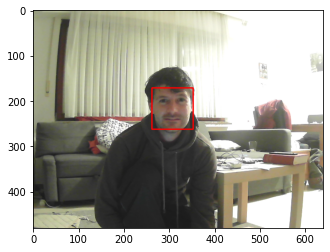

In [25]:
for i in range(10):
    display.clear_output(wait=True)
    
    start = time.time()
    
    # get the image from the webcam
    cap = cv2.VideoCapture(0)
    success = False
    _, img = cap.read()
    cap.release()
    # convert to RGB
    image = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # find the largest face
    boxes = classifier.detectMultiScale(image)
    bounding_boxes = [(x, y, x + width, y + height) for x, y, width, height in boxes ]
    bounding_boxes.sort(key=lambda box: (box[2]-box[0])*(box[3]-box[1]), reverse=True)
    
    if not bounding_boxes:
        continue
        
    (x1, y1, x2, y2) = bounding_boxes[0]
    face = image[y1:y2, x1:x2, :]
    
    cv2.rectangle(image, (x1, y1), (x2, y2), (255, 0, 0), 2)
    
    # convert the face to a grayscale Tensor
    face_tensor = PIL.Image.fromarray(face)
    face_tensor = transformer(face_tensor)
    face_tensor = face_tensor.to(device)
    face_tensor = face_tensor.view(1, 1, IMAGE_SIZE, IMAGE_SIZE)
    
    # predict the face expression probabilities
    with torch.no_grad():
        probs = nn.functional.softmax(model(face_tensor).detach().cpu(), dim=1)[0]

    # tahe the most likely expression (+ probability)
    label = torch.argmax(probs).item()

    print(f'Label: {labels_map[label]} {emoji_map[label]}, probability: {probs[label]}')
    print('E2E Latency:', time.time() - start)
    
    plt.imshow(image)
    plt.show()

    time.sleep(0.1)